In [17]:
import numpy as np
from copy import copy
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# N is the total number of permuted count tables to generate
N=1000000
#M is the number of individuals 
M=100

#generate synthetic SNP data array "x0"
#which is a 2xM array generated such that SNPs will each be in hardy-weinberg eq.,
#with a minor allele frequency of "p"
p=0.55
x0=np.random.rand(2,M)
x0=(x0>(p**2)).astype(int)+(x0>(p**2+2*p*(1-p))).astype(int)

#generate binary phenotype labels, where "p_f" have a value 0 (and 1-p_f have value 1)
p_f=0.66
p0=np.random.rand(M)
p0=(p0>p_f).astype(int)

#calculate un-permuted count table
C=np.zeros((2,3,3))
for i in range(3):
    for j in range(3):
        for k in range(2):
            C[k,i,j]=np.sum((x0[0]==i)&(x0[1]==j)&(p0==k))

### NAIVE METHOD ###
#initialize array to hold "N" 2x3x3 count tables
Cn=np.zeros((2,3,3,N))
for n in range(N):
    #at each iteration, shuffle the phenotype labels
    np.random.shuffle(p0)
    for i in range(3):
        for j in range(3):
            for k in range(2):
                #simply count and record how many of this combination exist given the shuffled phenotype label
                Cn[k,i,j,n]=np.sum((x0[0]==i)&(x0[1]==j)&(p0==k))

### OUR METHOD ###
# sum across first axis
### OUR METHOD ###
#stack together N of the original count tables, to then directly transform
C0=np.stack([C]*N,-1)
# sum across first axis to get genotype counts in each
nij=C0.sum(0).reshape(9,-1).astype(int)
#nrem[k] is the remaining total genotype counts at the k'th (i,j)
nrem=np.sum(nij,0)[None,:]-np.cumsum(nij,0)
#n0 is the total number of zero labels
n0=C0[0].sum(axis=(0,1)).ravel().astype(int)
#n0p is the total number of zero labels left to be assigned in the permuted tables
n0p=copy(n0)
#initialize "Co" array to store results from our method
Co=np.zeros(nij.shape)
for k in range(nij.shape[0]):
    #draw new phenotype labels for each (i,j) from hypergeometric distribution
    Co[k][n0p!=0]=np.random.hypergeometric(nij[k][n0p!=0],nrem[k][n0p!=0],n0p[n0p!=0])
    #subtract the number of labels already assigned to get updated number remaining
    n0p=(n0-np.sum(Co,0)).astype(int)
#reshape pheno=0 layer of each array back to 1x3x3
Co=Co.reshape((1,3,3,N))
#get value-1 labels by subtracting from value-0 labels from total at each (i,j)
Co=np.vstack([Co,nij.reshape(1,3,3,N)-Co])


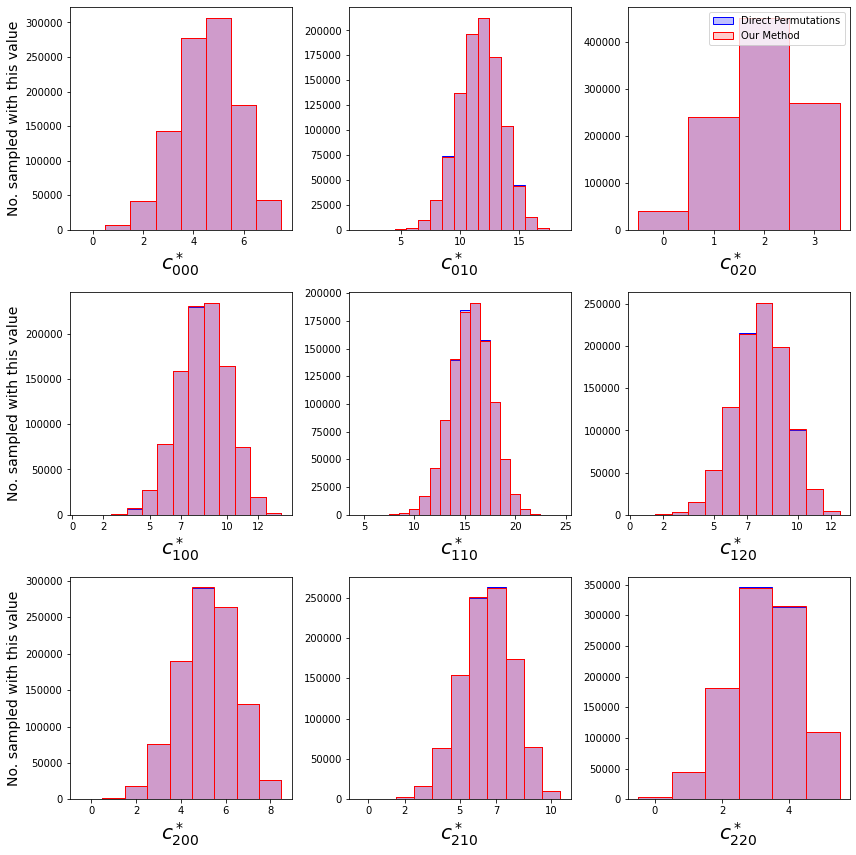

In [20]:
k=0

plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        #get range of bins by taking max/min of either approach, then define bins between these extremes
        b0,b1=np.minimum(np.min(Cn[k,i,j,:]),np.min(Co[k,i,j,:])),np.maximum(np.max(Cn[k,i,j,:]),np.max(Co[k,i,j,:]))
        bins=np.arange(b0-0.5,b1+1.5)
        #plot histograms generated by both methods
        _=plt.hist(Cn[k,i,j,:],bins,fc=[0,0,1,0.25],ec=[0,0,1,1],label='Direct Permutations')
        _=plt.hist(Co[k,i,j,:],bins,fc=[1,0.2,0.2,0.25],ec=[1,0,0],label='Our Method')
        #show labels as appropriate
        plt.xlabel('$c^*_{{{:}{:}{:}}}$'.format(i,j,k),fontsize=20)
        if (i==0)&(j==2):
            plt.legend()
        xt=plt.xticks()[0].astype(int)[1:-1]
        plt.xticks(xt)
        if j==0:
            plt.ylabel('No. sampled with this value',fontsize=14)
plt.tight_layout()

#plt.savefig('count_comparison.svg')

Text(0.5, 0, 'Multi-information $\\Omega$')

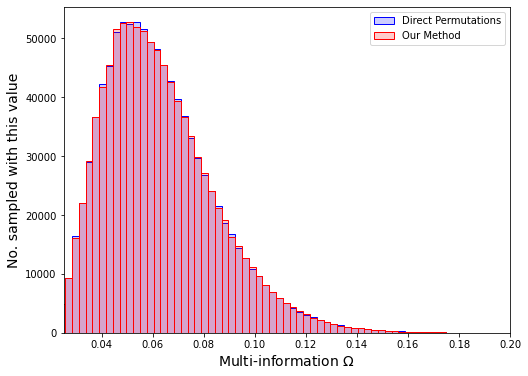

In [19]:
def count_to_omega(C):
    #function which will take the stacked count tables, calculate the component entropies,
    #and output the multi-information
    
    #normalize counts into probabilities
    P=C/np.sum(C,axis=(0,1,2))[None,None,None,:]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #compute all entropies
        H012=-np.nansum(P*np.log(P),axis=(0,1,2))
        H01=-np.nansum(np.sum(P,axis=(2))*np.log(np.sum(P,axis=(2))),axis=(0,1))
        H02=-np.nansum(np.sum(P,axis=(1))*np.log(np.sum(P,axis=(1))),axis=(0,1))
        H12=-np.nansum(np.sum(P,axis=(0))*np.log(np.sum(P,axis=(0))),axis=(0,1))
        H0=-np.nansum(np.sum(P,axis=(1,2))*np.log(np.sum(P,axis=(1,2))),axis=(0))
        H1=-np.nansum(np.sum(P,axis=(0,2))*np.log(np.sum(P,axis=(0,2))),axis=(0))
        H2=-np.nansum(np.sum(P,axis=(0,1))*np.log(np.sum(P,axis=(0,1))),axis=(0))
    #for Omega (multi-information)
    omega=(H0+H1+H2-H012).ravel()
    return omega

measure=np.vstack([count_to_omega(Cn),count_to_omega(Co)])

plt.figure(figsize=(8,6))
h0,bins,_=plt.hist(measure[0],80,fc=[0,0,1,0.2],edgecolor=[0,0,1],label='Direct Permutations')
h,_,_=plt.hist(measure[1],bins,fc=[1,0,0,0.2],edgecolor=[1,0,0],label='Our Method')
plt.xlim(0.025,0.2)
plt.legend()
plt.ylabel('No. sampled with this value',fontsize=14)
plt.xlabel('Multi-information $\Omega$',fontsize=14)
#plt.savefig('measure_comparison.svg')